In [1]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import glob
import torch.optim as optim
import time

import cv2
%matplotlib inline

In [26]:
# from google.colab import drive
# drive.mount('/gdrive')

In [27]:
# %cd ..
# %cd gdrive


In [28]:
# %ls MyDrive/AI_DATASET

In [2]:
data_dir = 'RSI-CB256/data/'
print(os.listdir(data_dir))

['cloudy', 'desert', 'green_area', 'water']


In [3]:
class CustomDataset(Dataset):
    def __init__(self,path,image_size):
        self.imgs_path = path
        file_list = glob.glob(self.imgs_path + "*")
        print(file_list)
        self.data = []
        for class_path in file_list:
            class_name = class_path.split("\\")[-1]
            for img_path in glob.glob(class_path + "/*.jpg"):
                self.data.append([img_path, class_name])
        print(self.data)
        self.class_map = {"desert" : 0, "water": 1,"green_area": 2,"cloudy": 3}
        self.img_dim = image_size
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        img_path, class_name = self.data[idx]
        img = cv2.imread(img_path)
        img = cv2.resize(img, self.img_dim)
        class_id = self.class_map[class_name]
        transform = transforms.Compose([transforms.ToTensor()])
        img_tensor = transform(img)
        mean, std, var = torch.mean(img_tensor), torch.std(img_tensor), torch.var(img_tensor)
        img_tensor = (img_tensor-mean)/std
        class_id = torch.tensor([class_id])
        return img_tensor, class_id

In [5]:
from torch.utils.data.sampler import SubsetRandomSampler

def load_data(path, test_split, val_split, batch_size, input_size, shuffle_dataset=True,random_seed=42):
    dataset = CustomDataset(path,input_size)	
    # Creating data indices for training and test splits:
    dataset_size = len(dataset)
    train_test_indices = list(range(dataset_size))
    test_split = int(np.floor(test_split * dataset_size))
    if shuffle_dataset :
        np.random.seed(random_seed)
        np.random.shuffle(train_test_indices)
    train_indices, test_indices = train_test_indices[test_split:], train_test_indices[:test_split]


   # Creating data indices for training and validation splits:
   
    train_data_size=len(train_indices)
    train_val_indices = list(range(train_data_size))
    val_split = int(np.floor(val_split * train_data_size))
    if shuffle_dataset :
        np.random.seed(random_seed)
        np.random.shuffle(train_val_indices)
    train_indices, val_indices = train_val_indices[val_split:], train_val_indices[:val_split]



    # Creating PT data samplers and loaders:
    train_sampler = SubsetRandomSampler(train_indices)
    test_sampler = SubsetRandomSampler(test_indices)
    val_sampler = SubsetRandomSampler(val_indices)

    data_loader_train = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                              sampler=train_sampler)
    data_loader_test = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                    sampler=test_sampler)

    data_loader_val = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                    sampler=val_sampler)


   
    print(len(data_loader_train),len(data_loader_test),len(data_loader_val))
    
    return data_loader_train, data_loader_test, data_loader_val

In [6]:
data_loader_train, data_loader_test, data_loader_val=load_data(data_dir,.2,.2,32,(64,64))

print(len(data_loader_val))

['RSI-CB256/data\\cloudy', 'RSI-CB256/data\\desert', 'RSI-CB256/data\\green_area', 'RSI-CB256/data\\water']
[['RSI-CB256/data\\cloudy\\train_10021.jpg', 'cloudy'], ['RSI-CB256/data\\cloudy\\train_10043.jpg', 'cloudy'], ['RSI-CB256/data\\cloudy\\train_10070.jpg', 'cloudy'], ['RSI-CB256/data\\cloudy\\train_10081.jpg', 'cloudy'], ['RSI-CB256/data\\cloudy\\train_10096.jpg', 'cloudy'], ['RSI-CB256/data\\cloudy\\train_101.jpg', 'cloudy'], ['RSI-CB256/data\\cloudy\\train_10128.jpg', 'cloudy'], ['RSI-CB256/data\\cloudy\\train_10166.jpg', 'cloudy'], ['RSI-CB256/data\\cloudy\\train_10173.jpg', 'cloudy'], ['RSI-CB256/data\\cloudy\\train_10177.jpg', 'cloudy'], ['RSI-CB256/data\\cloudy\\train_10201.jpg', 'cloudy'], ['RSI-CB256/data\\cloudy\\train_10224.jpg', 'cloudy'], ['RSI-CB256/data\\cloudy\\train_10225.jpg', 'cloudy'], ['RSI-CB256/data\\cloudy\\train_10231.jpg', 'cloudy'], ['RSI-CB256/data\\cloudy\\train_10263.jpg', 'cloudy'], ['RSI-CB256/data\\cloudy\\train_10265.jpg', 'cloudy'], ['RSI-CB256/d

In [7]:
def plot_data_loader(data_loader, gridDims):
    
    fig, axes = plt.subplots(nrows=gridDims[0], ncols=gridDims[1], figsize=(5,5))
    dataiter = iter(data_loader)
    for i in range(gridDims[0]):
        for j in range(gridDims[1]):
            images, _ = next(dataiter)
            axes[i, j].imshow(np.transpose(images[0].numpy(), (1, 2, 0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


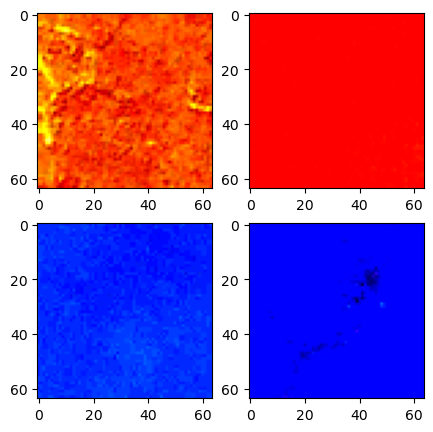

In [8]:
plot_data_loader(data_loader_test,[2,2])

In [9]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16', pretrained=False)


Using cache found in C:\Users\solan/.cache\torch\hub\pytorch_vision_v0.10.0
C:\Users\solan\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\solan\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [20]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [10]:
optimizer = optim.Adam(model.parameters(),lr=0.001);
criterion = nn.CrossEntropyLoss()

In [11]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))
model.to(device)

num_epochs = 30
total_steps = len(data_loader_train)
t1 = time.time()
Accuracy = []
Steps=[]
x=0
for epoch in range(num_epochs):
    for i, data in enumerate(data_loader_train):
        images, labels = data[0].to(device), data[1].to(device)
        labels=torch.flatten(labels)
        outputs = model(images)
        loss = criterion(outputs, labels)
        # Backprop and optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Train accuracy
        total = labels.size(0)
        _,predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        if (i + 1) % 100 == 0:
            x=x+100
            Accuracy.append(round((correct/total)*100, 2))
            Steps.append(x)
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, num_epochs, i + 1, total_steps, loss.item(),
                      (correct / total) * 100))
           
print("######## Training Finished in {} seconds ###########".format(time.time()-t1))

Device: cuda:0
Epoch [1/30], Step [100/113], Loss: 0.5637, Accuracy: 78.12%
Epoch [2/30], Step [100/113], Loss: 0.4726, Accuracy: 81.25%
Epoch [3/30], Step [100/113], Loss: 0.2827, Accuracy: 93.75%
Epoch [4/30], Step [100/113], Loss: 0.3982, Accuracy: 84.38%
Epoch [5/30], Step [100/113], Loss: 0.4768, Accuracy: 84.38%
Epoch [6/30], Step [100/113], Loss: 0.3780, Accuracy: 84.38%
Epoch [7/30], Step [100/113], Loss: 0.2455, Accuracy: 96.88%
Epoch [8/30], Step [100/113], Loss: 0.3661, Accuracy: 87.50%
Epoch [9/30], Step [100/113], Loss: 0.4513, Accuracy: 87.50%
Epoch [10/30], Step [100/113], Loss: 0.5197, Accuracy: 75.00%
Epoch [11/30], Step [100/113], Loss: 0.3348, Accuracy: 90.62%
Epoch [12/30], Step [100/113], Loss: 0.3353, Accuracy: 90.62%
Epoch [13/30], Step [100/113], Loss: 0.2239, Accuracy: 93.75%
Epoch [14/30], Step [100/113], Loss: 0.3775, Accuracy: 87.50%
Epoch [15/30], Step [100/113], Loss: 0.5776, Accuracy: 87.50%
Epoch [16/30], Step [100/113], Loss: 1.0103, Accuracy: 75.00%
Ep

In [12]:
model.eval() 
with torch.no_grad(): 
 correct = 0
 total = 0
 for data in data_loader_test:
  images, labels = data[0].to(device), data[1].to(device)
  labels=torch.flatten(labels)
  outputs = model(images)
  _, predicted = torch.max(outputs.data, 1)
  total += labels.size(0)
  correct += (predicted == labels).sum().item()
print('Test Accuracy of the model on the {} test images: {} %'
  .format(total, (correct / total) * 100))

Test Accuracy of the model on the 1126 test images: 69.89342806394316 %


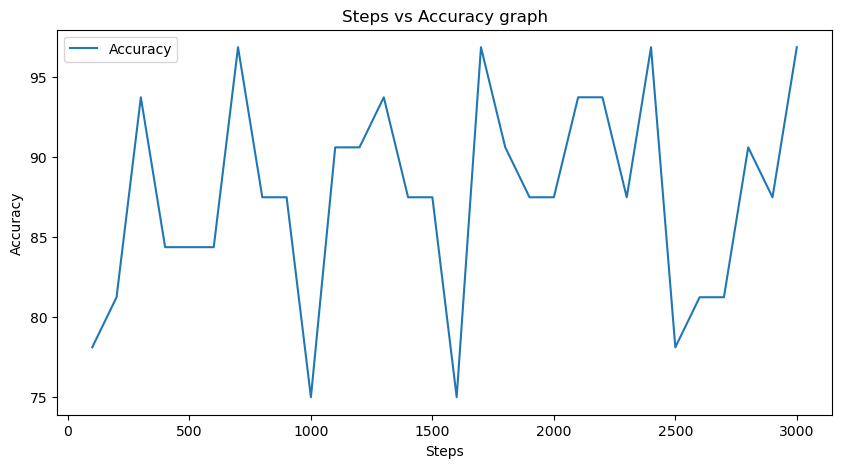

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.title("Steps vs Accuracy graph")
plt.plot(Steps, Accuracy, label="Accuracy")
plt.xlabel("Steps")
plt.ylabel("Accuracy")
plt.legend()
plt.show()